# New York City Taxi Passenger Dataset
This data set contains details of number of passengers using nyc_taxi for a period of six months- from 07/01/2014 to 01/31/2015.The total taxi passengers have been divided into a 30 minutes bucket. There are five anomalies occurring in this dataset:
1. NYC Marathon- 11/02/2014
2. Thanksgiving- 11/27/2014
3. Christmas- 12/25/2014
4. New Year's Day- 01/01/2015
5. Snow storm- 01/26/2015 and 01/27/2015

#### __Import Libraries__

In [148]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import rrcf
from sklearn.ensemble import IsolationForest
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

__Load the dataset into pandas dataframe__

In [149]:
taxi_data = pd.read_csv('nyc_taxi.csv',parse_dates=["timestamp"],index_col="timestamp")
data = taxi_data['value'].astype(float).values
print(taxi_data.head())
print(taxi_data.tail())

                     value
timestamp                 
2014-07-01 00:00:00  10844
2014-07-01 00:30:00   8127
2014-07-01 01:00:00   6210
2014-07-01 01:30:00   4656
2014-07-01 02:00:00   3820
                     value
timestamp                 
2015-01-31 21:30:00  24670
2015-01-31 22:00:00  25721
2015-01-31 22:30:00  27309
2015-01-31 23:00:00  26591
2015-01-31 23:30:00  26288


__Check and drop null values__

In [150]:
taxi_data=taxi_data.dropna()
taxi_data.isnull()

,value
timestamp,
2014-07-01 00:00:00,False
2014-07-01 00:30:00,False
2014-07-01 01:00:00,False
2014-07-01 01:30:00,False
2014-07-01 02:00:00,False
...,...
2015-01-31 21:30:00,False
2015-01-31 22:00:00,False
2015-01-31 22:30:00,False


__Describe datafarme__

In [151]:
taxi_data.dtypes

value    int64
dtype: object

__Visualize dataset__

<Figure size 1080x216 with 0 Axes>

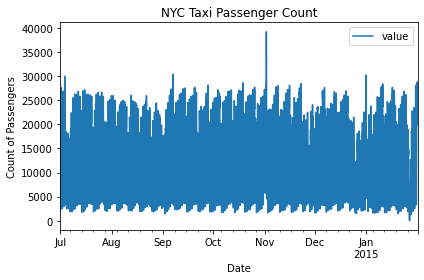

In [152]:
plt.figure(figsize=(15,3))
taxi_data.plot()
plt.title('NYC Taxi Passenger Count')
plt.ylabel('Count of Passengers')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [153]:
#Describe Dataset
taxi_data.describe()

,value
count,10320.000000
mean,15137.569380
std,6939.495808
min,8.000000
25%,10262.000000
50%,16778.000000
75%,19838.750000
max,39197.000000


__Create Events__

In [154]:
events = {
'nyc_marathon'     : ('2014-11-02 00:00:00',
                      '2014-11-03 00:00:00'),
'thanksgiving'     : ('2014-11-27 00:00:00',
                      '2014-11-28 00:00:00'),
'christmas'        : ('2014-12-25 00:00:00',
                      '2014-12-26 00:00:00'),
'new_year'         : ('2015-01-01 00:00:00',
                      '2015-01-02 00:00:00'),
'snow_storm'         : ('2015-01-26 00:00:00',
                      '2015-01-28 00:00:00')
}

#### Detect anomalies in the dataset
Create a column with with '0.0' as column value. Assign '1' for days with anomalies

In [155]:
taxi_data['event'] = np.zeros(len(taxi_data))
taxi_data.head()

,value,event
timestamp,,
2014-07-01 00:00:00,10844,0.0
2014-07-01 00:30:00,8127,0.0
2014-07-01 01:00:00,6210,0.0
2014-07-01 01:30:00,4656,0.0
2014-07-01 02:00:00,3820,0.0


In [156]:
for event, duration in events.items():
    start, end = duration
    taxi_data.loc[start:end, 'event'] = 1

#### Exploratory data analysis

In [157]:
# Mean of regular dataset and anlomalies
option=['0.0']
a= taxi_data[taxi_data['event'].isin(option)]
x= a.mean()
option=['1']
b= taxi_data[taxi_data['event'].isin(option)]
y= b.mean()
print("Mean of passengers without anomalies:", x)
print("Mean of passengers on anomalies data:", y)

Mean of passengers without anomalies: value    15281.442605
event        0.000000
dtype: float64
Mean of passengers on anomalies data: value    10213.962457
event        1.000000
dtype: float64


In [158]:
#Distribute dataset into normal and anomaly dates
normal= taxi_data[taxi_data['event']==0.0]
anomaly= taxi_data[taxi_data['event']==1]

In [159]:
print(normal.shape, anomaly.shape)

(10027, 2) (293, 2)


In [160]:
anomaly.describe()

,value,event
count,293.000000,293.0
mean,10213.962457,1.0
std,6567.877240,0.0
min,8.000000,1.0
25%,5159.000000,1.0
50%,10164.000000,1.0
75%,13990.000000,1.0
max,39197.000000,1.0


In [161]:
normal.describe()

,value,event
count,10027.000000,10027.0
mean,15281.442605,0.0
std,6897.713372,0.0
min,1279.000000,0.0
25%,10740.500000,0.0
50%,16895.000000,0.0
75%,19932.500000,0.0
max,30373.000000,0.0


#### Plotting data

In [162]:
#Random Forrest algorithm
num_trees = 200
shingle_size = 48
tree_size = 1000

In [163]:
#Creating a rolling window

points = rrcf.shingle(data, size=shingle_size)
points = np.vstack([point for point in points])
n = points.shape[0]
sample_size_range = (n // tree_size, tree_size)

In [164]:
forest = []
while len(forest) < num_trees:
    ixs = np.random.choice(n, size=sample_size_range,
                           replace=False)
    trees = [rrcf.RCTree(points[ix], index_labels=ix)
             for ix in ixs]
    forest.extend(trees)
    
avg_codisp = pd.Series(0.0, index=np.arange(n))
index = np.zeros(n)

In [165]:
for tree in forest:
    codisp = pd.Series({leaf : tree.codisp(leaf)
                        for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)
    
avg_codisp /= index
avg_codisp.index = taxi_data.iloc[(shingle_size - 1):].index

In [166]:
#Running isolation forrest
contamination = taxi_data['event'].sum()/len(taxi_data)
IF = IsolationForest(n_estimators=num_trees,
                     contamination=contamination,
                     behaviour='new',
                     random_state=0)
IF.fit(points)
if_scores = IF.score_samples(points)
if_scores = pd.Series(-if_scores,
                      index=(taxi_data
                             .iloc[(shingle_size - 1):]
                             .index))

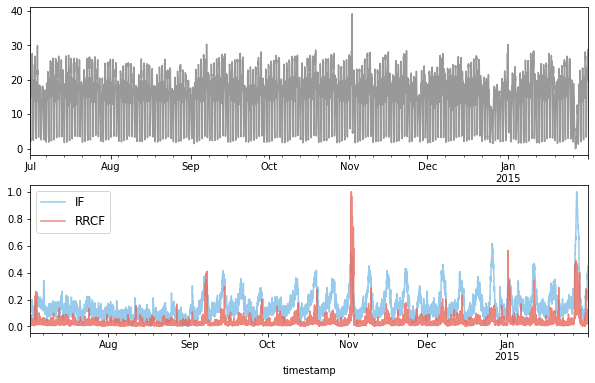

In [167]:
#Plot the dataset
avg_codisp = ((avg_codisp - avg_codisp.min())
              / (avg_codisp.max() - avg_codisp.min()))
if_scores = ((if_scores - if_scores.min())
              / (if_scores.max() - if_scores.min()))
              
fig, ax = plt.subplots(2, figsize=(10, 6))
(taxi_data['value'] / 1000).plot(ax=ax[0], color='0.5',
                            alpha=0.8)
if_scores.plot(ax=ax[1], color='#7EBDE6', alpha=0.8,
               label='IF')
avg_codisp.plot(ax=ax[1], color='#E8685D', alpha=0.8,
                label='RRCF')
ax[1].legend(frameon=True, loc=2, fontsize=12)

In [168]:
#Finding outliers
outlier_fraction=len(anomaly)/float(len(normal))

In [169]:
print(outlier_fraction)
print("Holidays", format(len(anomaly)))
print("Regular Days",format(len(normal)))

0.02922110302184103
Holidays 293
Regular Days 10027


In [170]:
#create independent and Dependent Features
columns = taxi_data.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["event"]]
# Store the variable we are predicting 
target = "event"
# Define a random state 
state = np.random.RandomState(42)
X = taxi_data[columns]
Y = taxi_data[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(10320, 1)
(10320,)


In [171]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams

##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

In [172]:
type(classifiers)

dict

In [173]:

n_outliers = len(anomaly)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for regular days , 1 for Anomalies
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 515
Accuracy Score :
0.9500968992248062
Classification Report :
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     10027
         1.0       0.13      0.14      0.13       293

    accuracy                           0.95     10320
   macro avg       0.55      0.56      0.55     10320
weighted avg       0.95      0.95      0.95     10320

Local Outlier Factor: 573
Accuracy Score :
0.9444767441860465
Classification Report :
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     10027
         1.0       0.03      0.03      0.03       293

    accuracy                           0.94     10320
   macro avg       0.50      0.50      0.50     10320
weighted avg       0.95      0.94      0.94     10320

Support Vector Machine: 4267
Accuracy Score :
0.586531007751938
Classification Report :
              precision    recall  f1-score   support

         0.0       0.97      0.59  

__Observations:__ Isolation forest detected 515 outliers, local outlier detected 573 outliers and support vector machine detected 4267 outlier. Isolation forest algorithm has the maximum accuracy of 95% followed by local outlier which is 94% accurate. Hence noted that isolation forest has much better performance in detection of anomalies compared to other two algorithms. 
